# 🔥🔥 Let's Make PubMed abstracts easier to read !! with : " Brief-Lit " 📄 🔥🔥


---



Confirming GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c84fb46c-39f8-cad6-52b0-9803f589003c)


## All Imports

In [2]:
!pip install tensorflow tensorflow-hub
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import tensorflow as tf # Importing tensorflow after reinstalling
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score  , accuracy_score
import tensorflow_hub as hub # Importing tensorflow_hub after reinstalling
import tf_keras

## Getting the Data

**PubMed 200k RCT dataset**

The PubMed 200k RCT dataset is described in Franck Dernoncourt, Ji Young Lee. PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts. International Joint Conference on Natural Language Processing (IJCNLP). 2017.

**[Abstract:](https://)**

PubMed 200k RCT is new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. The purpose of releasing this dataset is twofold. First, the majority of datasets for sequential short-text classification (i.e., classification of short texts that appear in sequences) are small: we hope that releasing a new large dataset will help develop more accurate algorithms for this task. Second, from an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 14.33 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt']

## Preprocess Data

In [6]:
# Reading The Lines  Of The Document

def get_lines(filename):
  with open(filename , "r") as f :
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"/train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()


      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples

In [10]:
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")

In [11]:
print("Length Of Training Samples : " , len(train_samples))
print("Length Of Validation Samples : " , len(val_samples))
print("Length Of Test Samples : " , len(test_samples))

Length Of Training Samples :  180040
Length Of Validation Samples :  30212
Length Of Test Samples :  30135


In [12]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
train_df["target"].value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


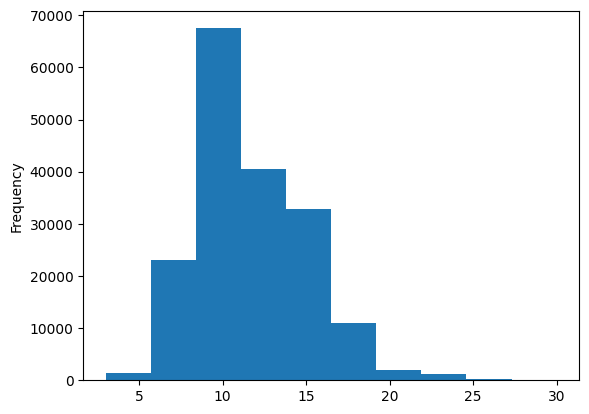

In [15]:
# Let's check the length of Different lines
train_df["total_lines"].plot.hist();

In [16]:
train_sentences = train_df["text"].tolist()
test_sentences = test_df["text"].tolist()
val_sentences = val_df["text"].tolist()

len(train_sentences) , len(test_sentences) , len(val_sentences)

(180040, 30135, 30212)

Transforming Numeric Labels :

One Hot Encoding

In [17]:
ohe_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = ohe_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1 , 1))
test_labels_one_hot = ohe_encoder.transform(test_df["target"].to_numpy().reshape(-1 , 1))
val_labels_one_hot = ohe_encoder.transform(val_df["target"].to_numpy().reshape(-1 , 1))

# Note : The fit_transform method of OneHotEncoder expects a 2D array as input. Reshaping the target column from a 1D array (single column) to a 2D array (with one row and many columns) allows the encoder to function properly. This is because it treats each sample as a row and each category as a column when creating the one-hot encoding.

Label Encoding

In [18]:
label_encoder = LabelEncoder()
train_labels_encoder = label_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1 , 1))
test_labels_encoder = label_encoder.transform(test_df["target"].to_numpy().reshape(-1 , 1))
val_labels_encoder = label_encoder.transform(val_df["target"].to_numpy().reshape(-1 , 1))
train_labels_encoder

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [19]:
def evaluation_metrics_tf(model , test_pred , test_labels) :
    accuracy = tf.keras.metrics.Accuracy()
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()

    # Updating state
    accuracy.update_state(test_pred , test_labels)
    precision.update_state(test_pred , test_labels)
    recall.update_state(test_pred , test_labels)

    # Evaluate Scores
    accuracy_score = accuracy.result().numpy()
    precision_score = precision.result().numpy()
    recall_score = recall.result().numpy()
    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score + 1e-7)
    confusion_matrix_tf = tf.math.confusion_matrix(test_labels , test_pred)

    # Results Disctionary
    results = {
        "Accuracy" : accuracy_score ,
        "Recall" : recall_score ,
        "Precision" : precision_score ,
        "F1-Score" : f1_score ,
        "Confusion Matrix" : confusion_matrix_tf
    }

    return results

## Experimentation Of Different Models :

### Model 0 : Getting a baseline model : " Machine Learing Based => Multinomial NB"

In [20]:
model_0 = Pipeline([
    ("tfid", TfidfVectorizer()),
    ("clf", MultinomialNB())
]
)


model_0.fit(train_sentences , train_labels_encoder)

Pipeline(steps=[('tfid', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(X= val_sentences ,
                 y= val_labels_encoder)

0.7218323844829869

In [22]:
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
def evaluation_metrics_sklearn(model , test_pred , test_labels) :
    accuracy = accuracy_score(test_labels , test_pred)
    precision = precision_score(test_labels, test_pred, average='weighted')
    recall = recall_score(test_labels , test_pred, average='weighted')
    f1= f1_score(test_labels , test_pred, average='weighted')
    confusion = confusion_matrix(test_labels , test_pred)
    results = {
        "Accuracy" : accuracy ,
        "Recall" : recall ,
        "Precision" : precision ,
        "F1-Score" : f1 ,
        "Confusion Matrix" : confusion
    }
    return results

In [24]:
model_0_results = evaluation_metrics_sklearn(test_labels= val_labels_encoder ,
                                    test_pred= model_0_preds , model=model_0)
model_0_results

{'Accuracy': 0.7218323844829869,
 'Recall': 0.7218323844829869,
 'Precision': 0.7186466952323352,
 'F1-Score': 0.6989250353450294,
 'Confusion Matrix': array([[1683,  794,  694,   97,  181],
        [ 244, 2687,  432,    5, 1214],
        [ 116,   75, 8670,    7, 1096],
        [ 505,  422,  978,  325,  146],
        [  20,  181, 1196,    1, 8443]])}

In [25]:
# from helper_functions import calculate_results
# model_0_results = calculate_results(y_true= val_labels_encoder ,
#                                     y_pred= model_0_preds)
# model_0_results

### Model 1 : " Conv 1D  "

In [26]:
# Lengths of Each Sentences
sentence_len_list = [len(sentence.split()) for sentence in train_sentences]
max_len = int(np.max(sentence_len_list))
min_len = int(np.min(sentence_len_list))
avg_len = int(np.mean(sentence_len_list))
_95_percentile_len = int(np.percentile(sentence_len_list , 95))
avg_len , max_len , min_len , _95_percentile_len

(26, 296, 1, 55)

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

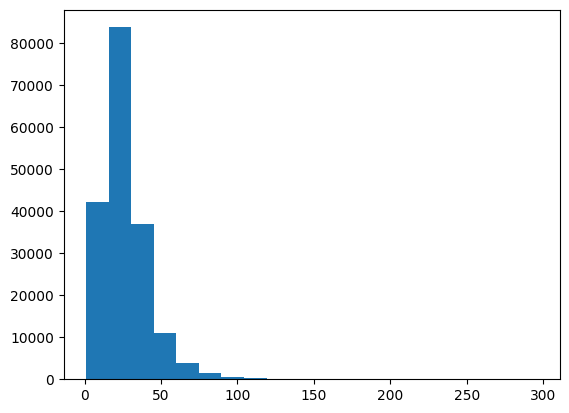

In [27]:
# Distribution of the lengths of the sentences
plt.hist(sentence_len_list , bins = 20)

In [28]:
# Vocab length
sentences_list = [sentence.split() for sentence in train_sentences]
word_list = list(itertools.chain.from_iterable(sentences_list))
vocab_len = len(set(word_list))
vocab_len

69732

#### Creating the Text Vectorizer

In [29]:
text_vectorizer = TextVectorization(max_tokens = vocab_len ,
                                    output_sequence_length = _95_percentile_len)

text_vectorizer.adapt(train_sentences)

In [30]:
vocab = text_vectorizer.get_vocabulary()
print(f"Length of vocab : {len(vocab)}")

Length of vocab : 64841


In [31]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 69732,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

 #### Creating embedding Layer

In [32]:
embedding_layer = layers.Embedding(input_dim=len(vocab),
                                   output_dim = 512 ,
                                   mask_zero = True ,
                                   name = "embedding_layer",
                                   )

In [33]:
# Checking a sample Vectorized and embedded sentence

sample_sentence = train_sentences[np.random.randint(0 , len(train_sentences))]
sample_sentence_vectorized = text_vectorizer([sample_sentence])
sample_sentence_embedded = embedding_layer(sample_sentence_vectorized)
print(f"Sample Sentence : {sample_sentence}")
print(f"Sample Sentence Vectorized : {sample_sentence_vectorized}")
print(f"Sample Sentence Embedded : {sample_sentence_embedded}")

Sample Sentence : pet received pethidine ( @ mg/kg ) , tra @ received tramadol ( @ mg/kg ) and tra @ received tramadol ( @ mg/kg ) ; all intramuscularly and associated with acepromazine ( @ mg/kg ) .
Sample Sentence Vectorized : [[ 5117    80  6761   618 11358    80  3612   618     3 11358    80  3612
    618    62  6507     3    81     7 11319   618     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sample Sentence Embedded : [[[ 0.04112103  0.00493743  0.01277724 ... -0.01214945  0.03522784
   -0.0118054 ]
  [ 0.04191952 -0.03777813  0.0267285  ... -0.04778628 -0.04441795
   -0.01834498]
  [ 0.01762278  0.01140648  0.02483389 ... -0.0414521  -0.01014335
   -0.01969739]
  ...
  [ 0.00184133  0.01562239  0.02456251 ... -0.02734877  0.00111729
    0.0438855 ]
  [ 0.00184133  0.01562239  0.02456251 ... -0.02734877  0.001117

Turning Our Datasets  Into TensorFlow Datasets:  "TensorFlow tf.data API"

In [34]:
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_labels_one_hot))
val_tf_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels_one_hot))
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_labels_one_hot))

In [35]:
# Prefected Datasets
train_tf_dataset= train_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_tf_dataset = val_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_tf_dataset = test_tf_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [36]:
train_tf_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [37]:
# Model Building
inputs = layers.Input(shape=(1,) , dtype=tf.string)
vectorized_text = text_vectorizer(inputs)
embedding_text = embedding_layer(vectorized_text)
x = layers.Conv1D(128 , kernel_size = 5 , padding="same" , activation ="relu")(embedding_text)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(train_df['target'].nunique() , activation="softmax")(x)
model_1 = tf.keras.Model(inputs , outputs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [38]:
# Compile Model
model_1.compile(loss="categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"])

In [39]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_layer (Embedding)          │ (None, 55, 512)             │      33,198,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 128)             │         327,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,527,045 (127.90 MB)

 Trainable params: 33,527,045 (127.90 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Fitting the model_1
model_1_history = model_1.fit(train_tf_dataset ,steps_per_epoch=int(0.1*len(train_tf_dataset)) ,  epochs = 5 , validation_data = val_tf_dataset , validation_steps = int(0.1*len(val_tf_dataset)))

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5804 - loss: 1.0448 - val_accuracy: 0.7723 - val_loss: 0.6450
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7661 - loss: 0.6432 - val_accuracy: 0.7832 - val_loss: 0.6016
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7859 - loss: 0.5932 - val_accuracy: 0.7939 - val_loss: 0.5659
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.7959 - loss: 0.5692 - val_accuracy: 0.7992 - val_loss: 0.5520
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7980 - loss: 0.5698 - val_accuracy: 0.8082 - val_loss: 0.5328


In [41]:
model_1.evaluate(val_tf_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8078 - loss: 0.5328


[0.5377309918403625, 0.807957112789154]

In [42]:
model_1_pred_probs = model_1.predict(val_tf_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([[6.2169462e-01, 1.5241483e-01, 2.6017692e-02, 1.6956010e-01,
        3.0312782e-02],
       [3.3061698e-01, 4.7472683e-01, 1.5565276e-02, 8.8828415e-02,
        9.0262473e-02],
       [1.5017055e-01, 1.0151404e-02, 2.8631396e-03, 8.3656812e-01,
        2.4680546e-04],
       ...,
       [4.3791246e-05, 4.8172782e-04, 6.3804178e-03, 3.6592304e-05,
        9.9305749e-01],
       [4.6110060e-02, 3.3830547e-01, 1.4998549e-01, 2.7987249e-02,
        4.3761173e-01],
       [1.0671464e-01, 8.4219575e-01, 4.1175544e-02, 3.4092385e-03,
        6.5048500e-03]], dtype=float32)

In [43]:
model_1_preds = tf.argmax(model_1_pred_probs , axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [44]:
model_1_results = evaluation_metrics_tf(model= model_1 ,test_labels=val_labels_encoder , test_pred=model_1_preds)
model_1_results

{'Accuracy': np.float32(0.8079571),
 'Recall': np.float32(0.9580176),
 'Precision': np.float32(0.94473714),
 'F1-Score': np.float32(0.9513309),
 'Confusion Matrix': <tf.Tensor: shape=(5, 5), dtype=int32, numpy=
 array([[2341,  480,  251,  343,   34],
        [ 499, 3307,  166,   32,  578],
        [ 176,   91, 9192,   63,  442],
        [ 754,  196,  180, 1226,   20],
        [  50,  427, 1015,    5, 8344]], dtype=int32)>}

### Model 2 : " Using Pretrained Token Embeddings  "

In [45]:
!pip install -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00


In [46]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sentence_transformers import SentenceTransformer
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

##### Creating Sentence Encoder

In [47]:
sentence_encoder = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

##### Preparing our dataset (Embedding the  train , text , validation dataset)

In [48]:
print("Encoding training sentences...")
train_embeddings = sentence_encoder.encode(train_sentences)
print("Encoding validation sentences...")
val_embeddings = sentence_encoder.encode(val_sentences)
print("Encoding test sentences...")
test_embeddings = sentence_encoder.encode(test_sentences)

Encoding training sentences...
Encoding validation sentences...
Encoding test sentences...


In [49]:
embedding_dim = train_embeddings.shape[1]  # Typically 384 for all-MiniLM-L6-v2
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 384


In [50]:
# Convert to TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_embeddings, train_labels_one_hot))
val_ds = tf.data.Dataset.from_tensor_slices((val_embeddings, val_labels_one_hot))
test_ds = tf.data.Dataset.from_tensor_slices((test_embeddings, test_labels_one_hot))

In [51]:
# Batch and prefetch
batch_size = 32
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [52]:
# Build the model directly without using a function
num_classes = train_df['target'].nunique()
inputs = layers.Input(shape=(embedding_dim,))

In [53]:
# Dense layers with ReLU activation
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

In [54]:
# Output layer
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model_2 = Model(inputs=inputs, outputs=outputs)

In [55]:
# Compile the model
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [56]:
# Model summary
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,101 (516.02 KB)

 Trainable params: 132,101 (516.02 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Train the model
model_2_history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.5963 - loss: 1.0305 - val_accuracy: 0.7117 - val_loss: 0.7547
Epoch 2/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7061 - loss: 0.7651 - val_accuracy: 0.7308 - val_loss: 0.7100
Epoch 3/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7243 - loss: 0.7213 - val_accuracy: 0.7403 - val_loss: 0.6819
Epoch 4/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7358 - loss: 0.6924 - val_accuracy: 0.7485 - val_loss: 0.6624
Epoch 5/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.7454 - loss: 0.6704 - val_accuracy: 0.7537 - val_loss: 0.6472
Epoch 6/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7519 - loss: 0.6535 - val_accuracy: 0.7587 - val_loss: 0.6363
Epoch 7/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7587 - loss: 0.6375 - val_accuracy: 0.7619 - val_loss: 0.6279
Epoch 8/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7645 - loss: 0

In [58]:
# Evaluate the model
test_loss, test_accuracy = model_2.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7638 - loss: 0.6291
Test Loss: 0.6240
Test Accuracy: 0.7675


In [59]:
model_2_pred_probs = model_2.predict(val_ds)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[2.7208528e-01, 5.2248156e-01, 6.6226609e-02, 1.0485871e-01,
        3.4347828e-02],
       [1.2003686e-01, 7.6883268e-01, 8.3608544e-03, 5.3797878e-02,
        4.8971649e-02],
       [3.1276157e-01, 1.6170661e-01, 1.1411494e-01, 4.0614703e-01,
        5.2697980e-03],
       ...,
       [6.1020063e-04, 3.0534528e-03, 4.5225773e-02, 3.2742057e-04,
        9.5078319e-01],
       [8.3764447e-03, 9.7842596e-02, 7.1410052e-02, 3.3114015e-03,
        8.1905949e-01],
       [6.0096301e-02, 8.2456362e-01, 7.8502789e-02, 4.6257484e-03,
        3.2211490e-02]], dtype=float32)

In [60]:
model_2_preds = tf.argmax(model_2_pred_probs , axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [61]:
model_2_results = evaluation_metrics_tf(model= model_2 ,test_labels=val_labels_encoder , test_pred=model_2_preds)
model_2_results

{'Accuracy': np.float32(0.76929694),
 'Recall': np.float32(0.945039),
 'Precision': np.float32(0.9470164),
 'F1-Score': np.float32(0.9460266),
 'Confusion Matrix': <tf.Tensor: shape=(5, 5), dtype=int32, numpy=
 array([[1975,  660,  323,  400,   91],
        [ 628, 2832,  269,  133,  720],
        [ 144,  126, 8841,  120,  733],
        [ 600,  344,  357, 1017,   58],
        [  46,  333,  858,   27, 8577]], dtype=int32)>}

### Model 3 : Conv 1D with "Character Encoding"

#### Creating character Level Embeddings

In [62]:
def split_chars(text):
  return " ".join(list(text))

In [63]:
# splitting sequence-level data splits into chanracter-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [64]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(149.3662574983337)

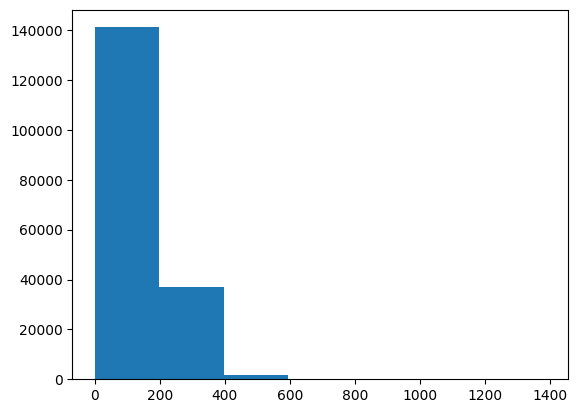

In [65]:
# Checking the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [66]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [67]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [69]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
5 least common characters: [np.str_('k'), np.str_('x'), np.str_('z'), np.str_('q'), np.str_('j')]


In [70]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=100,
                              mask_zero=False,
                              name="char_embed")

In [71]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{train_chars[30]}\n")
char_embed_example = char_embed(char_vectorizer([train_chars[30]]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
r e g r e s s i o n s   c o n t r o l l e d   f o r   a l a r m   s t a t u s   p r e i n t e r v e n t i o n   ;   d e m o g r a p h i c s   a n d   b e l i e f s   a b o u t   f i r e   r i s k s   a n d   a l a r m   e f f e c t i v e n e s s   .

Embedded chars (after vectorization and embedding):
[[[ 3.9312493e-02 -4.8823275e-02  1.6656663e-02 ...  4.5228750e-05
   -1.6601909e-02  1.3109770e-02]
  [ 1.2385868e-02 -3.3842422e-02 -2.6339186e-02 ... -2.1536315e-02
    5.6110397e-03 -2.2689402e-02]
  [-4.1786589e-02  5.1076189e-03 -3.5957158e-02 ... -2.0489693e-03
    4.5010004e-02  2.8548490e-02]
  ...
  [ 2.4791185e-02  1.1582486e-03  2.8617952e-02 ... -1.1006415e-02
   -1.8331073e-02  2.0652775e-02]
  [ 2.4791185e-02  1.1582486e-03  2.8617952e-02 ... -1.1006415e-02
   -1.8331073e-02  2.0652775e-02]
  [ 2.4791185e-02  1.1582486e-03  2.8617952e-02 ... -1.1006415e-02
   -1.8331073e-02  2.0652775e-02]]]

Character embedding shape: (1

#### Building The Model

In [72]:
inputs = layers.Input(shape=(1,) , dtype = "string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(128 , kernel_size = 5 , padding="same" , activation ="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(train_df['target'].nunique() , activation="softmax")(x)
model_3 = tf.keras.Model(inputs , outputs , name = "model_3_conv1d_char_embeddings")

In [73]:
model_3.compile(loss = "categorical_crossentropy" , optimizer = tf.keras.optimizers.Adam() , metrics = ["accuracy"])

In [74]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 100)            │           7,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 128)            │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,773 (280.36 KB)

 Trainable params: 71,773 (280.36 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=10,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3514 - loss: 1.4510 - val_accuracy: 0.4355 - val_loss: 1.3171
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4532 - loss: 1.3164 - val_accuracy: 0.4834 - val_loss: 1.2681
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4769 - loss: 1.2729 - val_accuracy: 0.5013 - val_loss: 1.2429
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4951 - loss: 1.2312 - val_accuracy: 0.5130 - val_loss: 1.1968
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5072 - loss: 1.1921 - val_accuracy: 0.5289 - val_loss: 1.1632
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5294 - loss: 1.1617 - val_accuracy: 0.5479 - val_loss: 1.1257
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5334 - loss: 1.1461 - val_accuracy: 0.5535 - val_loss: 1.0984
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5475 - loss: 1.1176 - val_accuracy: 0

#### Evaluating our model

In [77]:
model_3.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5612 - loss: 1.0650


[1.0669031143188477, 0.5593472719192505]

In [78]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([[0.17971806, 0.29502994, 0.28635475, 0.11567389, 0.12322333],
       [0.08129604, 0.18104891, 0.13757117, 0.03757114, 0.56251276],
       [0.1627659 , 0.1453803 , 0.28104308, 0.29919505, 0.11161562],
       ...,
       [0.00598569, 0.01113029, 0.10776273, 0.00286331, 0.872258  ],
       [0.02301231, 0.07022353, 0.17125161, 0.03833352, 0.69717896],
       [0.22520845, 0.28243202, 0.25002575, 0.04972203, 0.19261175]],
      dtype=float32)

In [79]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 3, ..., 4, 4, 1])>

In [80]:
model_3_results = evaluation_metrics_tf(model = model_3 , test_labels=val_labels_encoder,test_pred=model_3_preds)
model_3_results

{'Accuracy': np.float32(0.5593473),
 'Recall': np.float32(0.89502233),
 'Precision': np.float32(0.9802339),
 'F1-Score': np.float32(0.9356921),
 'Confusion Matrix': <tf.Tensor: shape=(5, 5), dtype=int32, numpy=
 array([[ 372,  539, 1015,  340, 1183],
        [ 215, 1156,  914,  169, 2128],
        [ 102,  118, 6428,   94, 3222],
        [ 198,  348,  662,  517,  651],
        [  14,  139, 1229,   33, 8426]], dtype=int32)>}

### Model4 : Combining Pretrained Embeddings + Characters Embeddings (hybrid Embedding)
- Create a token-level embedding model
- Crate a character-level model
- Building a series of output layers
- construct a modle which takes character-level sequences as input and produces sequence label probabilities as output

#### Create a token-level embedding model

In [81]:
# # Define the custom Sentence Encoder Layer
# class SentenceEncoderLayer(tf.keras.layers.Layer):
#     def __init__(self, model_name='all-MiniLM-L6-v2', **kwargs):
#         super(SentenceEncoderLayer, self).__init__(**kwargs)
#         self.model_name = model_name
#         self.encoder = SentenceTransformer(model_name)
#         self.trainable = False  # Set to True if you want it to be trainable
#         self.output_dim = self.encoder.get_sentence_embedding_dimension()

#     def build(self, input_shape):
#         # This ensures the layer knows its output shape
#         self.built = True

#     def call(self, inputs):
#         # Remove extra dimension if needed: inputs shape might be (batch_size, 1)
#         inputs = tf.squeeze(inputs, axis=1)
#         return tf.py_function(
#             func=self._encode_sentences,
#             inp=[inputs],
#             Tout=tf.float32
#         )

#     def _encode_sentences(self, sentences):
#         # Convert tensor to list of strings
#         if isinstance(sentences, tf.Tensor):
#             sentences = [s.decode('utf-8') for s in sentences.numpy()]

#         # Get embeddings
#         embeddings = self.encoder.encode(sentences)
#         return tf.convert_to_tensor(embeddings, dtype=tf.float32)

#     def compute_output_shape(self, input_shape):
#         # Specify the output shape explicitly
#         return (input_shape[0], self.output_dim)

#     def get_config(self):
#         config = {
#             'model_name': self.model_name
#         }
#         base_config = super(SentenceEncoderLayer, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

In [82]:
# # Setup token input branch
# token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_input_main")
# sentence_encoder_layer = SentenceEncoderLayer()
# token_embeddings = sentence_encoder_layer(token_inputs)
# # Ensure the shape is set explicitly after processing
# # token_embeddings = tf.reshape(token_embeddings, [-1, sentence_encoder_layer.output_dim])
# token_output = layers.Dense(128, activation="relu")(token_embeddings)
# token_model = tf.keras.Model(inputs=token_inputs,
#                             outputs=token_output)

In [83]:
# token_model.summary()

#### Crate a character-level model

In [84]:
# # 2. Setting up char inputs/model
# char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
# char_vectors = char_vectorizer(char_inputs)
# char_embeddings = char_embed(char_vectors)
# char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
# char_model = tf.keras.Model(inputs=char_inputs,
#                             outputs=char_bi_lstm)

In [85]:
# char_model.summary()

#### Building a series of output layers

In [86]:
# # 3. Concatenating token and char inputs (create hybrid token embedding)
# token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
#                                                                   char_model.output])

In [87]:
# # 4. Creating output layers - adding of dropout
# combined_dropout = layers.Dropout(0.5)(token_char_concat)
# combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
# final_dropout = layers.Dropout(0.5)(combined_dense)
# output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [88]:
# # 5. Constructing the model with char and token inputs
# model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
#                          outputs=output_layer,
#                          name="model_4_token_and_char_embeddings")

In [89]:
# model_4.summary()

In [90]:
# # Plot and visualizations
# from keras.utils import plot_model
# plot_model(model_4 , show_shapes=True)

#### Compiling the model

In [91]:
# # Combine Char + token model
# model_4.compile(loss = "categorical_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics =["accuracy"])

#### Combining token and character data into a tf.data Dataset

In [92]:

# # Combine chars and tokens into a dataset
# train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
# train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
# train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# # Prefetch and batch train data
# train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# # Repeat same steps validation data
# val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
# val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
# val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
# val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#### Fitting the model

In [93]:
# model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
#                               steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
#                               epochs=10,
#                               validation_data=val_char_token_dataset,
#                               validation_steps=int(0.1 * len(val_char_token_dataset)))

In [94]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from sentence_transformers import SentenceTransformer
import numpy as np

# For reproducibility (optional)
tf.random.set_seed(42)

# Define the number of classes for the final prediction (adjust as needed)
num_classes = train_labels_one_hot.shape[1]


In [95]:
# Initialize the SentenceTransformer model
sent_encoder = SentenceTransformer('all-MiniLM-L6-v2')
output_dim = sent_encoder.get_sentence_embedding_dimension()

# Precompute embeddings for training and validation sentences
train_sentence_embeddings = sent_encoder.encode(train_sentences, show_progress_bar=True)
val_sentence_embeddings = sent_encoder.encode(val_sentences, show_progress_bar=True)

# Convert the embeddings to float32 numpy arrays (or tensors later)
train_sentence_embeddings = np.array(train_sentence_embeddings, dtype=np.float32)
val_sentence_embeddings = np.array(val_sentence_embeddings, dtype=np.float32)


Batches:   0%|          | 0/5627 [00:00<?, ?it/s]

Batches:   0%|          | 0/945 [00:00<?, ?it/s]

In [96]:
# Define the numeric input for precomputed sentence embeddings
token_input = layers.Input(shape=(output_dim,), dtype=tf.float32, name="token_input_main")
# Optionally, add a fully connected layer
token_dense = layers.Dense(128, activation="relu")(token_input)

# Create a model for the token branch
token_model = Model(inputs=token_input, outputs=token_dense, name="token_branch")


In [97]:
# Define character input, assuming each example is a single string (shape=())
char_input = layers.Input(shape=(), dtype=tf.string, name="char_input")

# Example: using a TextVectorization layer to tokenize the char input.
# Adjust parameters as needed. Here we assume a maximum of 100 characters (you can adjust).
max_chars = 100
char_vectorizer = layers.TextVectorization(max_tokens=2000, output_mode='int', output_sequence_length=max_chars)
# If you haven't adapted the vectorizer yet, do it on training data (convert input to a tf.data.Dataset of strings)
char_vectorizer.adapt(train_chars)

# Create an embedding layer for characters (vocab_size matches the vectorizer's output size)
vocab_size = char_vectorizer.vocabulary_size()
char_embed = layers.Embedding(input_dim=vocab_size, output_dim=64)

# Process the char input through the vectorizer and embedding layers
char_vectors = char_vectorizer(char_input)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)

# Build a model for the char branch
char_model = Model(inputs=char_input, outputs=char_bi_lstm, name="char_branch")


In [98]:
# Concatenate the outputs of the token branch and the char branch
combined = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# Add dropout and dense layers as needed
x = layers.Dropout(0.5)(combined)
x = layers.Dense(200, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(num_classes, activation="softmax")(x)

# Construct the final multi-input model
model_4 = Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name="model_4_token_and_char_embeddings")

# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4.summary()


Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_1      │ (None, 100)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input_main          │ (None, 384)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 64)        │          1,792 │ text_vectorization_1[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         49,280 │ token_input_main[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50)             │         18,000 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 178)            │              0 │ dense_5[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 178)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 200)            │         35,800 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 200)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 5)              │          1,005 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 105,877 (413.58 KB)

 Trainable params: 105,877 (413.58 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Build a tf.data.Dataset that provides the token embeddings and char inputs along with labels

# For training:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "token_input_main": train_sentence_embeddings,  # numeric embeddings
        "char_input": train_chars                        # raw text characters
    },
    train_labels_one_hot
))
train_dataset = train_dataset.batch(8).prefetch(tf.data.AUTOTUNE)

# For validation:
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "token_input_main": val_sentence_embeddings,
        "char_input": val_chars
    },
    val_labels_one_hot
))
val_dataset = val_dataset.batch(8).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Train the model (adjust steps_per_epoch and validation_steps as appropriate)
model_4_history = model_4.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)


Epoch 1/10


### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [1]:

# Inspect training dataframe
train_df.head()

NameError: name 'train_df' is not defined